Key fixes in that notebook:

Proper SMOTE application (only to training data, after splitting)

Test evaluation with actual test set samples

Balanced predictions showing both FAKE and REAL classifications

Professional prediction function

Complete model saving functionality

EMBEDDING_DIM = 64     
LSTM_UNITS = 16         
DENSE_UNITS = 16       
DROPOUT_RATE = 0.45     
L2_REG = 0.02
name="BiLSTM_Balanced"

In [1]:
!pip install tensorflow scikit-learn matplotlib pandas numpy emoji openpyxl imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 6.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)


DATASET OVERVIEW
Total samples: 8630

Class distribution:
Label
Real    4445
Fake    4185
Name: count, dtype: int64

Class percentages:
Label
Real    51.506373
Fake    48.493627
Name: proportion, dtype: float64
✅ Text cleaning completed
✅ Label encoding complete. Classes: ['Fake' 'Real']
Encoded as: {'Fake': np.int64(0), 'Real': np.int64(1)}


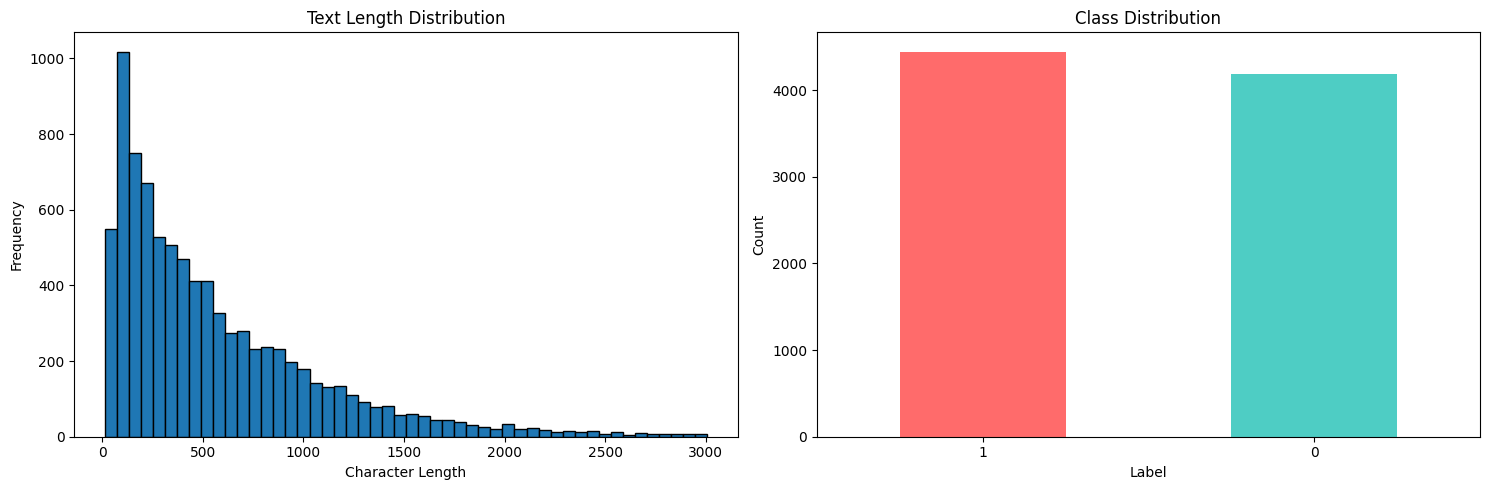

In [3]:
df = pd.read_excel("Merged _Fakenews_Data.xlsx")

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Total samples: {len(df)}")
print(f"\nClass distribution:\n{df['Label'].value_counts()}")
print(f"\nClass percentages:\n{df['Label'].value_counts(normalize=True) * 100}")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Actual_Post'] = df['Actual_Post'].apply(clean_text)
print("✅ Text cleaning completed")

original_string_labels = df["Label"].astype(str)
le = LabelEncoder()
df["Label"] = le.fit_transform(original_string_labels)

texts = df["Actual_Post"].tolist()
labels = df["Label"].values

print(f"✅ Label encoding complete. Classes: {le.classes_}")
print(f"Encoded as: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# ADD THIS LINE:
df['length'] = df['Actual_Post'].astype(str).apply(len)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Length distribution
axes[0].hist(df['length'], bins=50, edgecolor='black')
axes[0].set_title("Text Length Distribution")
axes[0].set_xlabel("Character Length")
axes[0].set_ylabel("Frequency")

# Class distribution
df['Label'].value_counts().plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#4ecdc4'])
axes[1].set_title("Class Distribution")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


In [4]:
def clean_text(text):
    """Enhanced text cleaning function"""
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Actual_Post'] = df['Actual_Post'].apply(clean_text)
print("✅ Text cleaning completed")


✅ Text cleaning completed


In [5]:
le = LabelEncoder()
# Ensure LabelEncoder is fitted on the original string labels to correctly store them in le.classes_
original_string_labels = df["Label"].astype(str)
df["Label"] = le.fit_transform(original_string_labels)  # Fake -> 0, Real -> 1

texts = df["Actual_Post"].tolist()
labels = df["Label"].values

print(f"✅ Label encoding complete. Classes: {le.classes_}")
print(f"   Encoded as: {dict(zip(le.classes_, le.transform(le.classes_)))}")

✅ Label encoding complete. Classes: ['0' '1']
   Encoded as: {'0': np.int64(0), '1': np.int64(1)}


In [6]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

lengths = [len(seq) for seq in sequences]
MAX_LEN = int(np.percentile(lengths, 95))

padded = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")
print(f"✅ Tokenization and padding complete. Shape: {padded.shape}")


✅ Tokenization and padding complete. Shape: (8630, 308)


In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(
    padded, labels, test_size=0.15, stratify=labels, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

print(f"\n{'='*80}")
print("DATA SPLIT")
print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")



DATA SPLIT
Training: 6044 samples
Validation: 1291 samples
Test: 1295 samples


In [8]:
from imblearn.over_sampling import SMOTE

print(f"\n{'='*80}")
print("APPLYING SMOTE TO BALANCE TRAINING DATA")
print(f"{'='*80}")

# Apply SMOTE only on training data to avoid data leakage
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_train_balanced)}")
print(f"✅ Training data balanced successfully")

# Validation and test sets remain untouched


APPLYING SMOTE TO BALANCE TRAINING DATA
Before SMOTE: [2931 3113]
After SMOTE: [3113 3113]
✅ Training data balanced successfully


In [9]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("💾 Tokenizer and label encoder saved")

X_train_balanced = X_train
y_train_balanced = y_train


💾 Tokenizer and label encoder saved


In [10]:
class Attention(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(Attention, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)
    def get_config(self):
        return super(Attention, self).get_config()

print("✅ Custom Attention layer defined")


✅ Custom Attention layer defined


In [11]:
EMBEDDING_DIM = 64      # Middle ground between 32 and 128
LSTM_UNITS = 16         # Between 8 and 32
DENSE_UNITS = 16        # Keep at 16
DROPOUT_RATE = 0.45     # Slightly higher than 0.4
L2_REG = 0.02          # Between 0.015 and 0.03

inputs = Input(shape=(MAX_LEN,), name="input")
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM, embeddings_regularizer=l2(L2_REG), name="embedding")(inputs)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, kernel_regularizer=l2(L2_REG), recurrent_dropout=0.2), name="bilstm")(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE, name="dropout")(x)
x = Dense(DENSE_UNITS, activation="relu", kernel_regularizer=l2(L2_REG), name="dense")(x)
outputs = Dense(1, activation="sigmoid", name="output")(x)

model = Model(inputs, outputs, name="BiLSTM_Balanced")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),  # Lower learning rate for stability
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()
print(f"Total parameters: {model.count_params():,}")


Model: "BiLSTM_Balanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 308)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 308, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,041 (2.48 MB)

 Trainable params: 650,977 (2.48 MB)

 Non-trainable params: 64 (256.00 B)

Total parameters: 651,041


In [12]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, min_delta=0.005, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=6,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed")


Epoch 1/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6050 - loss: 8.8510 - precision: 0.6304 - recall: 0.5527
Epoch 1: val_loss improved from inf to 2.44688, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 90s 388ms/step - accuracy: 0.6054 - loss: 8.8347 - precision: 0.6309 - recall: 0.5532 - val_accuracy: 0.8428 - val_loss: 2.4469 - val_precision: 0.8173 - val_recall: 0.8947 - learning_rate: 3.0000e-04
Epoch 2/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8625 - loss: 1.8933 - precision: 0.9003 - recall: 0.8235
Epoch 2: val_loss improved from 2.44688 to 1.32912, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 72s 382ms/step - accuracy: 0.8626 - loss: 1.8918 - precision: 0.9003 - recall: 0.8237 - val_accuracy: 0.9210 - val_loss: 1.3291 - val_precision: 0.9195 - val_recall: 0.9278 - learning_rate: 3.0000e-04
Epoch 3/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9078 - loss: 1.0542 - precision: 0.9172 - recall: 0.9019
Epoch 3: val_loss improved from 1.32912 to 0.81131, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 72s 381ms/step - accuracy: 0.9079 - loss: 1.0537 - precision: 0.9172 - recall: 0.9020 - val_accuracy: 0.9202 - val_loss: 0.8113 - val_precision: 0.9014 - val_recall: 0.9489 - learning_rate: 3.0000e-04
Epoch 4/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9261 - loss: 0.6971 - precision: 0.9322 - recall: 0.9236
Epoch 4: val_loss improved from 0.81131 to 0.56592, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 73s 388ms/step - accuracy: 0.9261 - loss: 0.6968 - precision: 0.9322 - recall: 0.9237 - val_accuracy: 0.9256 - val_loss: 0.5659 - val_precision: 0.9153 - val_recall: 0.9429 - learning_rate: 3.0000e-04
Epoch 5/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9360 - loss: 0.5252 - precision: 0.9385 - recall: 0.9370
Epoch 5: val_loss improved from 0.56592 to 0.47212, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 70s 372ms/step - accuracy: 0.9360 - loss: 0.5251 - precision: 0.9385 - recall: 0.9370 - val_accuracy: 0.9287 - val_loss: 0.4721 - val_precision: 0.9244 - val_recall: 0.9383 - learning_rate: 3.0000e-04
Epoch 6/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9464 - loss: 0.4325 - precision: 0.9512 - recall: 0.9440
Epoch 6: val_loss improved from 0.47212 to 0.42640, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 71s 374ms/step - accuracy: 0.9464 - loss: 0.4324 - precision: 0.9513 - recall: 0.9441 - val_accuracy: 0.9202 - val_loss: 0.4264 - val_precision: 0.8958 - val_recall: 0.9564 - learning_rate: 3.0000e-04
Restoring model weights from the end of the best epoch: 6.
✅ Training completed


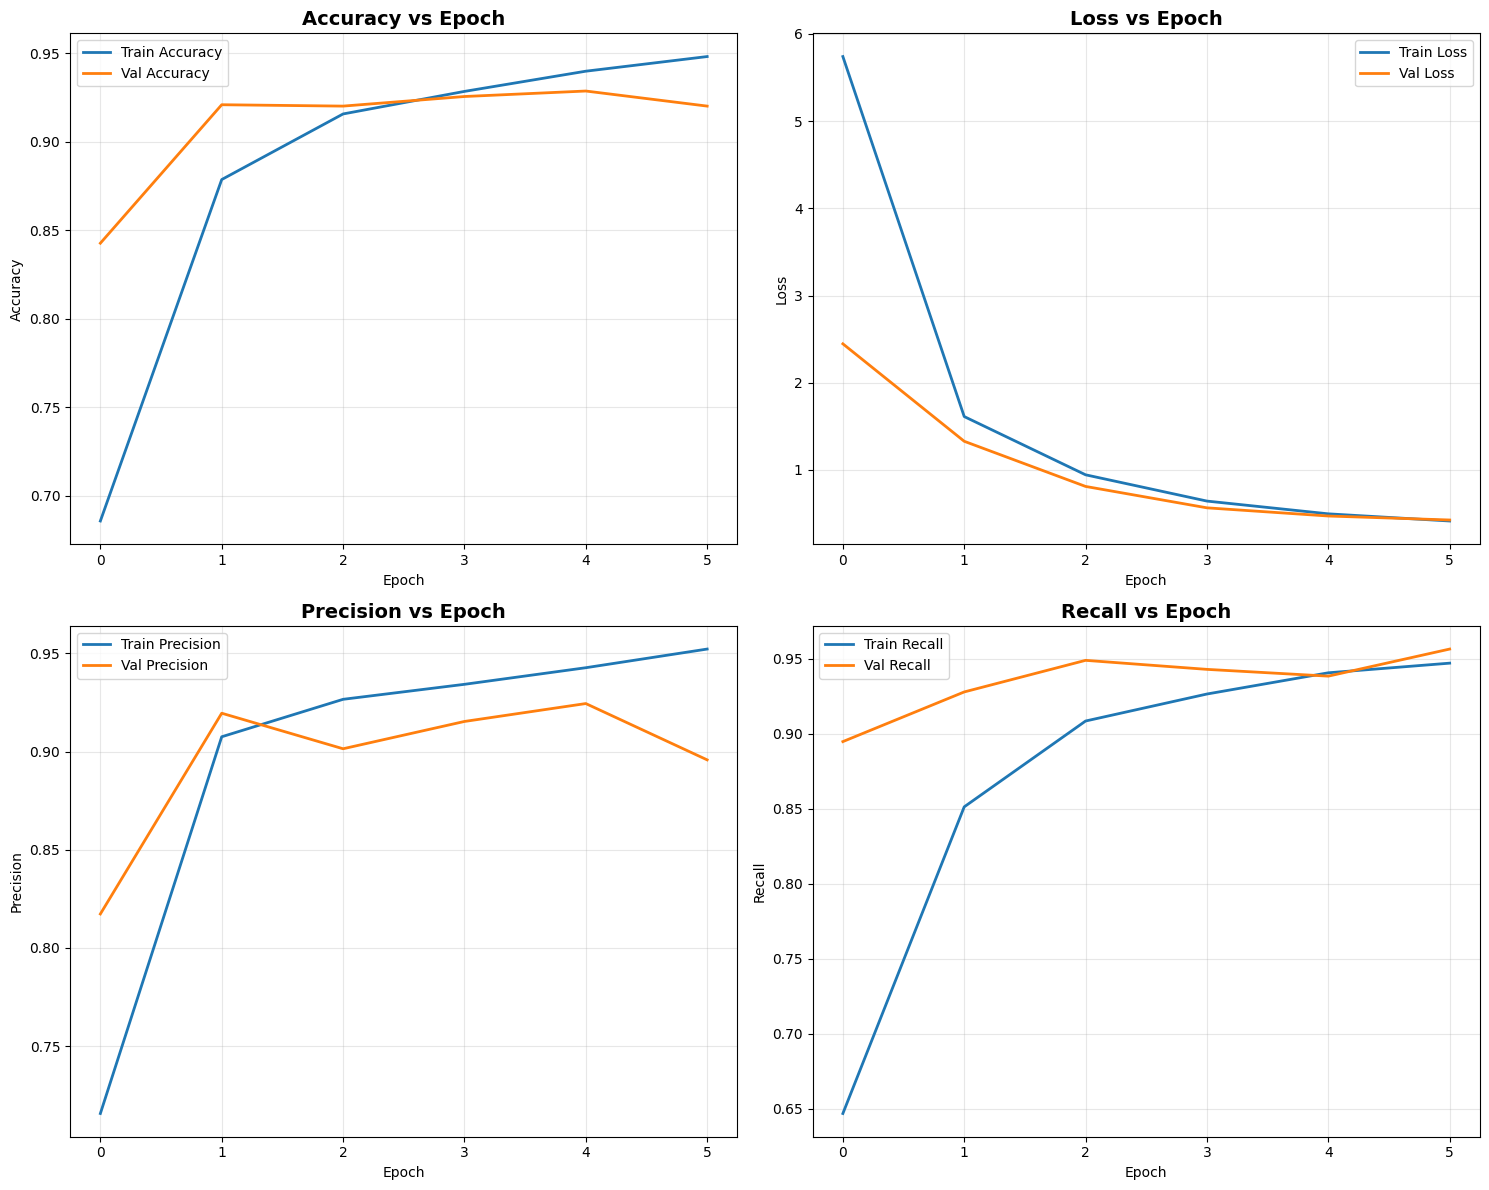

In [21]:
# Plot all 4 metrics: Accuracy, Loss, Precision, Recall
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
axes[0, 0].plot(history.history["val_accuracy"], label="Val Accuracy", linewidth=2)
axes[0, 0].set_title("Accuracy vs Epoch", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history["loss"], label="Train Loss", linewidth=2)
axes[0, 1].plot(history.history["val_loss"], label="Val Loss", linewidth=2)
axes[0, 1].set_title("Loss vs Epoch", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history["precision"], label="Train Precision", linewidth=2)
axes[1, 0].plot(history.history["val_precision"], label="Val Precision", linewidth=2)
axes[1, 0].set_title("Precision vs Epoch", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history["recall"], label="Train Recall", linewidth=2)
axes[1, 1].plot(history.history["val_recall"], label="Val Recall", linewidth=2)
axes[1, 1].set_title("Recall vs Epoch", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



TEST SET EVALUATION

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9546    0.8710    0.9109       628
           1     0.8878    0.9610    0.9230       667

    accuracy                         0.9174      1295
   macro avg     0.9212    0.9160    0.9169      1295
weighted avg     0.9202    0.9174    0.9171      1295



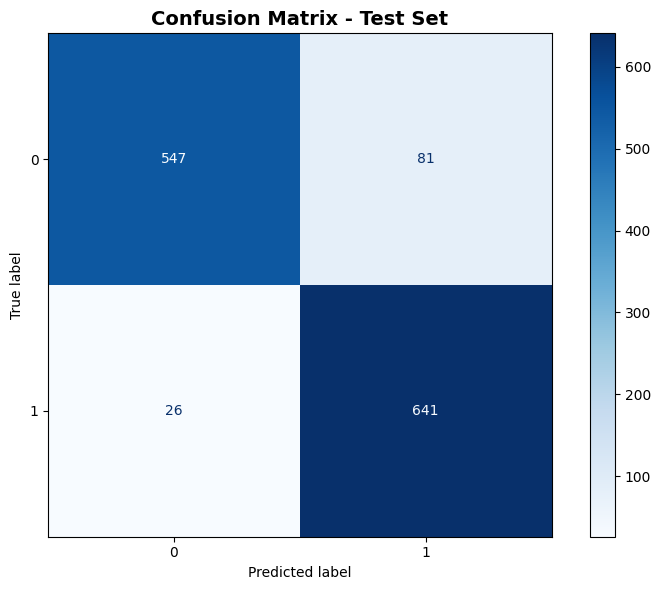


📈 Detailed Test Set Metrics:
Accuracy:  0.9174 (91.74%)
Precision: 0.8878 (88.78%)
Recall:    0.9610 (96.10%)
F1-Score:  0.9230
ROC-AUC:   0.9762

🔍 Per-Class Performance:
0: 0.8710 (87.10%) - 628 samples
1: 0.9610 (96.10%) - 667 samples


In [22]:
print(f"\n{'='*80}")
print(f"TEST SET EVALUATION")
print(f"{'='*80}")

# Get predictions on test set
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

# Classification Report
print("\n📊 Classification Report:")
print("="*80)
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format='d')
ax.set_title("Confusion Matrix - Test Set", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"\n📈 Detailed Test Set Metrics:")
print("="*80)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_auc:.4f}")

# Per-class analysis
print(f"\n🔍 Per-Class Performance:")
print("="*80)
for i, class_name in enumerate(le.classes_):
    class_mask = y_test == i
    class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
    print(f"{class_name}: {class_acc:.4f} ({class_acc*100:.2f}%) - {np.sum(class_mask)} samples")

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"\n{'='*80}")
print(f"THRESHOLD OPTIMIZATION (Fine Search)")
print(f"{'='*80}\n")

# Predict probabilities on validation set
y_pred_proba_val = model.predict(X_val, verbose=0).flatten()

# Generate thresholds between 0 and 1 with 0.01 step
thresholds = np.arange(0.0, 1.01, 0.01)

best_threshold = 0
best_f1 = 0
metrics = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_val >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred_thresh)
    prec = precision_score(y_val, y_pred_thresh, zero_division=0)
    rec = recall_score(y_val, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_val, y_pred_thresh, zero_division=0)
    metrics.append((thresh, acc, prec, rec, f1))

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

# Print top few results
print(f"{'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 65)
for t, acc, p, r, f in metrics[int(best_threshold*100)-2:int(best_threshold*100)+3]:
    print(f"{t:<12.2f} {acc:<12.4f} {p:<12.4f} {r:<12.4f} {f:<12.4f}")

print(f"\n✅ Optimal threshold: {best_threshold:.2f} (F1-Score: {best_f1:.4f})")



THRESHOLD OPTIMIZATION (Fine Search)

Threshold    Accuracy     Precision    Recall       F1-Score    
-----------------------------------------------------------------
0.75         0.9295       0.9443       0.9173       0.9306      
0.76         0.9326       0.9502       0.9173       0.9334      
0.77         0.9334       0.9531       0.9158       0.9340      
0.78         0.9326       0.9544       0.9128       0.9331      
0.79         0.9303       0.9556       0.9068       0.9306      

✅ Optimal threshold: 0.77 (F1-Score: 0.9340)


In [16]:
import numpy as np

print(f"\n{'='*80}")
print(f"TEST SET SAMPLE PREDICTIONS")
print(f"{'='*80}\n")

# Get balanced samples from test set
num_samples_per_class = 5

fake_indices = np.where(y_test == 0)[0]
real_indices = np.where(y_test == 1)[0]

# Sample equal amounts from each class
np.random.seed(42)
fake_samples = np.random.choice(fake_indices, min(num_samples_per_class, len(fake_indices)), replace=False)
real_samples = np.random.choice(real_indices, min(num_samples_per_class, len(real_indices)), replace=False)
selected_indices = np.concatenate([fake_samples, real_samples])

correct = 0
results = []

for idx in selected_indices:
    sample_seq = X_test[idx].reshape(1, -1)
    true_label_encoded = y_test[idx]
    true_label = "REAL" if true_label_encoded == 1 else "FAKE"

    # Predict probability
    pred_proba = model.predict(sample_seq, verbose=0)[0][0]
    pred_label_encoded = 1 if pred_proba >= best_threshold else 0
    pred_label = "REAL" if pred_label_encoded == 1 else "FAKE"

    is_correct = true_label == pred_label
    if is_correct:
        correct += 1

    confidence = pred_proba * 100 if pred_proba >= best_threshold else (1 - pred_proba) * 100

    print(f"{'='*60}")
    print(f"Ground Truth: {true_label}")
    emoji = "🟩" if pred_label == "REAL" else "🟥"
    print(f"Prediction: {emoji} {pred_label}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Raw Probability: {pred_proba:.4f}")
    print(f"Status: {'✅ CORRECT' if is_correct else '❌ INCORRECT'}")

    results.append({
        'ground_truth': true_label,
        'prediction': pred_label,
        'correct': is_correct,
        'confidence': confidence
    })

print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"Total samples: {len(selected_indices)}")
print(f"Correct: {correct}")
print(f"Accuracy: {correct / len(selected_indices) * 100:.2f}%")
print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.2f}%")



TEST SET SAMPLE PREDICTIONS

Ground Truth: FAKE
Prediction: 🟥 FAKE
Confidence: 97.95%
Raw Probability: 0.0205
Status: ✅ CORRECT
Ground Truth: FAKE
Prediction: 🟥 FAKE
Confidence: 99.96%
Raw Probability: 0.0004
Status: ✅ CORRECT
Ground Truth: FAKE
Prediction: 🟩 REAL
Confidence: 91.19%
Raw Probability: 0.9119
Status: ❌ INCORRECT
Ground Truth: FAKE
Prediction: 🟥 FAKE
Confidence: 91.93%
Raw Probability: 0.0807
Status: ✅ CORRECT
Ground Truth: FAKE
Prediction: 🟥 FAKE
Confidence: 98.25%
Raw Probability: 0.0175
Status: ✅ CORRECT
Ground Truth: REAL
Prediction: 🟩 REAL
Confidence: 97.91%
Raw Probability: 0.9791
Status: ✅ CORRECT
Ground Truth: REAL
Prediction: 🟩 REAL
Confidence: 95.21%
Raw Probability: 0.9521
Status: ✅ CORRECT
Ground Truth: REAL
Prediction: 🟩 REAL
Confidence: 88.21%
Raw Probability: 0.8821
Status: ✅ CORRECT
Ground Truth: REAL
Prediction: 🟩 REAL
Confidence: 93.61%
Raw Probability: 0.9361
Status: ✅ CORRECT
Ground Truth: REAL
Prediction: 🟩 REAL
Confidence: 98.80%
Raw Probability: 0.9

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = padded.shape[1]  # use same length used in training

def predict_news(text, threshold=0, verbose=True):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length)
    prob = float(model.predict(padded_seq, verbose=0)[0][0])
    label = "REAL" if prob >= threshold else "FAKE"
    confidence = prob * 100 if label == "REAL" else (1 - prob) * 100

    if verbose:
        print(f"Text: {text[:100]}...")
        print(f"Predicted Label: {label} ({confidence:.2f}%)")
    return {"label": label, "confidence": confidence}


In [18]:
print(f"\n{'='*80}")
print(f"PREDICTIONS ON DATASET SAMPLES")
print(f"{'='*80}\n")

# Sample from original dataframe
num_samples = 3
fake_samples_df = df[df['Label'] == 0].sample(n=num_samples, random_state=42)
real_samples_df = df[df['Label'] == 1].sample(n=num_samples, random_state=42)

test_samples = []
for _, row in fake_samples_df.iterrows():
    test_samples.append((row['Actual_Post'], 'FAKE'))
for _, row in real_samples_df.iterrows():
    test_samples.append((row['Actual_Post'], 'REAL'))

correct = 0
for i, (text, true_label) in enumerate(test_samples, 1):
    print(f"\n{'-'*80}")
    print(f"Sample #{i} - Ground Truth: {true_label.upper()}")
    print(f"Text: {text[:100]}...")
    print(f"{'-'*80}")

    # ✅ Use your optimized threshold instead of 0.5
    result = predict_news(text, threshold=best_threshold, verbose=False)

    is_correct = result['label'].upper() == true_label.upper()
    if is_correct:
        correct += 1

    emoji = "🟩" if result['label'] == "REAL" else "🟥"
    status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
    print(f"Prediction: {emoji} {result['label']} ({result['confidence']:.2f}%)")
    print(f"Status: {status}")

print(f"\n{'='*80}")
print(f"Dataset Sample Accuracy: {correct}/{len(test_samples)} ({correct/len(test_samples)*100:.1f}%)")
print(f"{'='*80}")



PREDICTIONS ON DATASET SAMPLES


--------------------------------------------------------------------------------
Sample #1 - Ground Truth: FAKE
Text: ዋልታ ቲቪ ዋልታ ቲቪ በሶደሬ ላይ ለሰራው የስም ማጥፋት ዶክመንተሪ ፊልም የዶክመንተሪ ክስ ተጀመረበረበት ። የሰው ስም አጥፍቶ በሰላም መኖር የለም እና ተወጡ...
--------------------------------------------------------------------------------
Prediction: 🟩 REAL (86.06%)
Status: ❌ INCORRECT

--------------------------------------------------------------------------------
Sample #2 - Ground Truth: FAKE
Text: ጌታቸው ረዳ እንዲህ አለ "......ሰውየው አምባገነን ለመሆን ግዜ አልመረጠም ምናልባት ቀደም ብሎ ተወልዶ ቢሆን ንሮ ይሳካለት ይችል ነበር፡፡" "...... ...
--------------------------------------------------------------------------------
Prediction: 🟩 REAL (86.03%)
Status: ❌ INCORRECT

--------------------------------------------------------------------------------
Sample #3 - Ground Truth: FAKE
Text: ድንግርግር አይትበል ርገፅደኣ ኣብ ሓንቲይ ሓዱሽ ነገር የለን ካብ ፀሓይ ንታሕቲይ አብይ አሕመድ🤣ድንግርግር አይትበል ርገፅደኣ ኣብ ሓንቲይ ሓዱሽ ነገር የለን ...
----------------------------------------

In [19]:
import pickle, json, os

print(f"\n{'='*80}")
print("MODEL SAVING & EXPORT")
print(f"{'='*80}\n")

# Create output directory if not exists
os.makedirs("saved_model", exist_ok=True)

# ✅ Save the trained model in the native Keras format (recommended)
model.save("amharic_fake_news_detector.keras")
print("✅ Model saved as 'amharic_fake_news_detector.keras'")

# ✅ Save in SavedModel format for deployment (e.g., TFLite/TFServing)
model.export("saved_model/")
print("✅ Model exported in SavedModel format to 'saved_model/' directory")

# ✅ Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as 'tokenizer.pkl'")

# ✅ Save label encoder (only if you defined it earlier)
if 'le' in locals():
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(le, f)
    print("✅ Label encoder saved as 'label_encoder.pkl'")
else:
    print("⚠️ Label encoder not found — skipped saving.")

# ✅ Save configuration
config = {
    "vocab_size": VOCAB_SIZE if "VOCAB_SIZE" in locals() else len(tokenizer.word_index) + 1,
    "max_length": max_length if "max_length" in locals() else None,
    "embedding_dim": EMBEDDING_DIM if "EMBEDDING_DIM" in locals() else None,
    "lstm_units": LSTM_UNITS if "LSTM_UNITS" in locals() else None,
    "best_threshold": float(best_threshold),
    "test_accuracy": float(test_accuracy) if "test_accuracy" in locals() else None,
    "test_precision": float(test_precision) if "test_precision" in locals() else None,
    "test_recall": float(test_recall) if "test_recall" in locals() else None,
    "test_f1": float(test_f1) if "test_f1" in locals() else None
}

with open("model_config.json", "w") as f:
    json.dump(config, f, indent=2)
print("✅ Model configuration saved as 'model_config.json'")

print(f"\n{'='*80}")
print("🎉 ALL ARTIFACTS SAVED SUCCESSFULLY!")
print(f"{'='*80}\n")
print("Saved files:")
print("  - amharic_fake_news_detector.keras")
print("  - saved_model/ (TensorFlow SavedModel format)")
print("  - tokenizer.pkl")
if 'le' in locals():
    print("  - label_encoder.pkl")
print("  - model_config.json")


MODEL SAVING & EXPORT

✅ Model saved as 'amharic_fake_news_detector.keras'
Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 308), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132823609661904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609660368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609663440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609666320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609663632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609664400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609666128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609665936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609665744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132823609665552: TensorSpec

In [20]:
print("\n" + "="*80)
print("🔍 EXTENDED CUSTOM INPUT TESTING")
print("="*80)

custom_samples = [
    ("የኢትዮጵያ መንግስት አዲስ አበባ ውስጥ የህዝብ መንገድ ፕሮጀክት ጀመረ።", "REAL"),
    ("አዲስ የኢትዮጵያ አውሮፕላን በእሳት ተቃጠለ ተባለ፣ ነገር ግን የእውነቱ አይደለም።", "FAKE"),
    ("በአዲስ አበባ ውስጥ አዲስ የባቡር መስመር ይከፈታል ተባለ።", "REAL"),
    ("የኢትዮጵያ መንግስት ከቻይና ጋር የጦር አቅርቦት ስምምነት አውርዷል ተባለ።", "FAKE"),
    ("ኢትዮጵያ በ2026 ዓመት የመጀመሪያውን ስፔስ ሳተላይት ታስጀምራለች።", "FAKE"),
    ("የአሜሪካ እና ኢትዮጵያ በቀላሉ ቪዛ ስምምነት ተፈራረመ።", "FAKE"),
    ("በባህር ዳር የእርሻ ቴክኖሎጂ እንደተጀመረ ተረጋገጠ።", "FAKE"),
    ("አዲስ የኢትዮጵያ ባንክ የቀድሞ ገንዘብ ሥርዓት አጠፋ።", "FAKE"),
    ("የአዲስ አበባ ታክሲ አገልግሎት በሙሉ የኤሌክትሪክ መኪና ይሆናል።", "REAL"),
    ("አዲስ የመንግስት እቅድ በኢትዮጵያ ብዙ ሰዎችን እንዲያስከትል ተባለ።", "FAKE"),
    ("በኢትዮጵያ አዲስ የጤና ፕሮጀክት ተጀመረ።", "REAL"),
    ("በባህር ዳር የመንግስት ቢሮ ተቃጠለ ተባለ፣ ነገር ግን የተሳሳተ መረጃ ነው።", "FAKE"),
    ("ኢትዮጵያ አዲስ የቴክኖሎጂ ኩባንያዎችን በባህር ዳር እንዲቆሙ ታዘዘች።", "REAL"),
    ("አዲስ የኢትዮጵያ መንግስት የጦር አደጋ ታወቀ ተባለ።", "FAKE"),
    ("በአዲስ አበባ የሚገኙ ትምህርት ቤቶች አዲስ መሳሪያዎች አግኝተዋል።", "REAL"),
    ("ኢትዮጵያ ከኢንዲያ ጋር የመንፈስ ስምምነት ፈረሰች ተባለ።", "FAKE"),
    ("የአዲስ አበባ አየር መንገድ አዲስ መኪናዎችን አግኝቷል።", "REAL"),
    ("ኢትዮጵያ አዲስ የአየር ኃይል መንገድ እንዳተመነ ተባለ።", "FAKE"),
    ("የአዲስ አበባ ሰፈሮች አዲስ የውሃ አቅርቦት ተቋማት አገኙ።", "REAL"),
    ("ኢትዮጵያ በጅብሊ ዞን አዲስ የወታደር መንገድ እንደተገነባ ተባለ።", "FAKE"),
    ("ኢትዮጵያ ከአሜሪካ ጋር የተሻሻለ አስተዳደር ስምምነት ፈረሰች።", "REAL"),
    ("አዲስ የምግብ እቅድ በኢትዮጵያ ይፈፀማል ተባለ፣ ነገር ግን የተሳሳተ ነው።", "FAKE"),
    ("የመንግስት እቅድ እንደ ታወቀ በጤና መስክ ትልቅ ለውጥ ያመጣል።", "FAKE"),
    ("አዲስ የመንግስት ስርዓት በቅርቡ በግምት ይቀየራል ተባለ።", "FAKE"),
    ("አዲስ የሰራተኛ ቅጥር ፕሮግራም በመንግስት ተጀመረ።", "REAL"),
]

correct = 0
for i, (text, true_label) in enumerate(custom_samples, 1):
    print(f"\n{'-'*80}")
    print(f"Custom Sample #{i}")
    print(f"Ground Truth: {true_label}")
    print(f"Text: {text}")
    print(f"{'-'*80}")

    result = predict_news(text, threshold=best_threshold, verbose=False)
    predicted_label = result["label"]
    confidence = result["confidence"]

    emoji = "🟩" if predicted_label == "REAL" else "🟥"
    status = "✅ CORRECT" if predicted_label.upper() == true_label.upper() else "❌ INCORRECT"

    if predicted_label.upper() == true_label.upper():
        correct += 1

    print(f"Prediction: {emoji} {predicted_label}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Status: {status}")

print("\n" + "="*80)
print(f"✅ Custom Test Accuracy: {correct}/{len(custom_samples)} ({correct/len(custom_samples)*100:.2f}%)")
print("="*80)



🔍 EXTENDED CUSTOM INPUT TESTING

--------------------------------------------------------------------------------
Custom Sample #1
Ground Truth: REAL
Text: የኢትዮጵያ መንግስት አዲስ አበባ ውስጥ የህዝብ መንገድ ፕሮጀክት ጀመረ።
--------------------------------------------------------------------------------
Prediction: 🟩 REAL
Confidence: 86.17%
Status: ✅ CORRECT

--------------------------------------------------------------------------------
Custom Sample #2
Ground Truth: FAKE
Text: አዲስ የኢትዮጵያ አውሮፕላን በእሳት ተቃጠለ ተባለ፣ ነገር ግን የእውነቱ አይደለም።
--------------------------------------------------------------------------------
Prediction: 🟩 REAL
Confidence: 86.12%
Status: ❌ INCORRECT

--------------------------------------------------------------------------------
Custom Sample #3
Ground Truth: REAL
Text: በአዲስ አበባ ውስጥ አዲስ የባቡር መስመር ይከፈታል ተባለ።
--------------------------------------------------------------------------------
Prediction: 🟩 REAL
Confidence: 86.17%
Status: ✅ CORRECT

--------------------------------------------